In [120]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve, ShuffleSplit, RandomizedSearchCV
import joblib

In [121]:
le_man = joblib.load('../le_man.sklearn')
le_sel = joblib.load('../le_sel.sklearn')
le_cat = joblib.load('../le_cat.sklearn')
le_sub = joblib.load('../le_sub.sklearn')

In [122]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [123]:
train = pd.read_csv('../data/amazon_train.csv')
test = pd.read_csv('../data/amazon_test.csv')

In [124]:
train.head()

,manufacturer,price,number_of_reviews,average_review_rating,sellers,cat,sub_cat,name,info,desc,reviews
0,987,8.44,2.0,5.0,549,34,14,0.605606,-1.305917,-1.993160,1.824300
1,1574,209.99,2.0,4.0,699,13,116,3.528918,-1.269589,-1.730482,-4.421398
2,1663,4.00,3.0,5.0,81,14,46,-3.511665,-0.837028,-2.297708,-3.458916
3,2342,19.99,1.0,5.0,160,7,140,0.836036,-1.123865,-2.583533,-2.375369
4,2105,1.49,77.0,4.5,387,0,97,1.504637,5.455937,-1.236510,-2.221026


We are going to split our test data into a validation and test set so that we have a validation set to help tune our model with. 

In [125]:
x_train = train.drop('price', 1)
y_train = train['price']
x_test = test.drop('price', 1)
y_test = test['price']

In [126]:
lgb = LGBMRegressor(random_state=0)
cross_val_score(lgb, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

-15.822044681061533

<module 'matplotlib.pyplot' from 'C:\\Users\\nelso\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

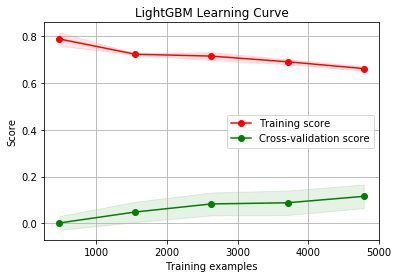

In [127]:
plot_learning_curve(lgb, 'LightGBM Learning Curve', x_train, y_train, cv=5)

In [128]:
lgb = LGBMRegressor(objective = 'regression_l1',
                    subsample = 0.1,
                     random_state = 0,
                     num_leaves = 120,
                     n_estimators = 1000,
                     min_split_gain = 0.06999,
                     min_data_in_leaf = 12,
                     max_depth = 56,
                     learning_rate = 0.005,
                     colsample_bytree = 0.4,
                     boosting_type = 'gbdt')

<module 'matplotlib.pyplot' from 'C:\\Users\\nelso\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

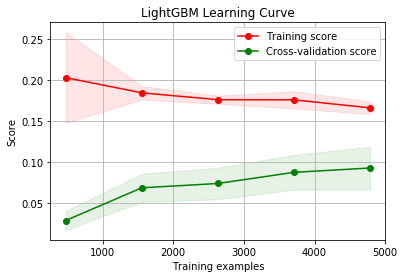

In [129]:
plot_learning_curve(lgb, 'LightGBM Learning Curve', x_train, y_train, cv=5)

In [130]:
lgb.fit(x_train, y_train)
preds = lgb.predict(x_test)

In [131]:
test['pred'] = preds
test['error'] = abs(test['pred'] - test['price'])

In [132]:
mean_absolute_error(preds, y_test)

12.420001987285415

In [133]:
categories = test['cat'].unique()[test['cat'].value_counts()>10]

In [134]:
test.shape

(2564, 13)

In [135]:
test[test['cat'].isin(categories)].shape

(2523, 13)

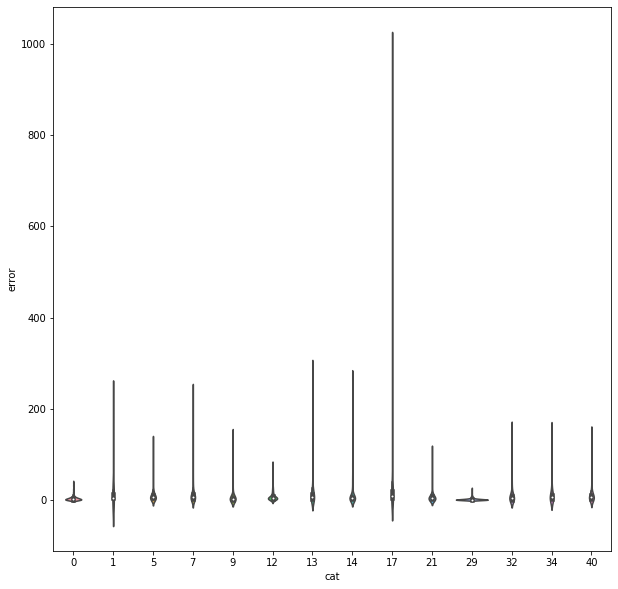

In [136]:
f, ax = plt.subplots(figsize=(10,10))
sns.violinplot('cat', 'error', data=test[test['cat'].isin(categories)])

In [138]:
test['cat'] = le_cat.inverse_transform(test['cat'])
test['manufacturer'] = le_man.inverse_transform(test['manufacturer'])
test['sellers'] = le_sel.inverse_transform(test['sellers'])
test['sub_cat'] = le_sub.inverse_transform(test['sub_cat'])

In [139]:
test.groupby('cat')['error'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)

,mean,std,count
cat,,,
Electronic Toys,53.182440,NaN,1
Hobbies,26.848957,71.986452,359
Baby & Toddler Toys,23.358374,54.541233,24
Pretend Play,17.323362,21.325989,10
Figures & Playsets,15.614138,33.995603,259
Die-Cast & Toy Vehicles,14.176903,25.913779,346
Sports Toys & Outdoor,14.110148,26.055589,89
unk,11.891608,21.069789,159
Musical Toy Instruments,11.656345,7.438922,6


In [140]:
test.sort_values(by='error', ascending=False)[0:20]

,manufacturer,price,number_of_reviews,average_review_rating,sellers,cat,sub_cat,name,info,desc,reviews,pred,error
1884,DJI,995.11,4.0,5.0,"""Amazon.co.uk""",Hobbies,Remote Controlled Devices,4.773282,-1.746144,-2.223019,-3.634391,13.065174,982.044826
1947,Bushiroad,629.95,1.0,5.0,"""Japan_Hobby_Shop""",Hobbies,Trading Cards & Accessories,-4.129386,-0.918844,0.303174,-4.580268,28.862349,601.087651
2153,Revell-Monogram,486.95,2.0,5.0,"""Japan_Hobby_Shop""",Hobbies,Model Building Kits,0.530502,-1.378829,-2.258621,0.475140,27.469527,459.480473
10,Star images,299.93,2.0,5.0,"""NEXTLEVELUKNET""",Figures & Playsets,Science Fiction & Fantasy,-7.580363,-1.398842,-1.464365,0.915647,14.891590,285.038410
2262,Bandai,303.12,3.0,4.7,"""Smaller World Future""",Figures & Playsets,Science Fiction & Fantasy,-4.792458,5.653130,-0.664587,-3.680137,21.752761,281.367239
2118,Screenlife,283.00,1.0,5.0,"""Glendora Unique Store""",Games,DVD Games,1.209151,-1.437046,-2.913302,-2.449086,11.905066,271.094934
1709,Product Enterprise,256.45,6.0,5.0,"""*IMMEDIATE* dispatch *FAST* delivery *UK*SELL...",Die-Cast & Toy Vehicles,Toy Vehicles & Accessories,-1.547266,-1.387640,-2.412349,-3.866206,17.729895,238.720105
1121,Kotobukiya,266.24,1.0,5.0,unk,Hobbies,Collectible Figures & Memorabilia,-1.826888,-1.410937,-1.777209,-4.022656,27.583333,238.656667
1519,Trumpeter,226.40,1.0,5.0,"""Online-Shopping-Mall""",Figures & Playsets,Military,3.576487,-1.079656,-1.281654,5.824041,14.852582,211.547418
675,sideshow weta,219.99,1.0,5.0,"""galadhrim_store""",Hobbies,Collectible Figures & Memorabilia,-1.076615,6.767507,-1.731272,-0.602731,13.447135,206.542865


In [76]:
pd.DataFrame(zip(lgb.feature_importances_, x_train.columns)).sort_values(by=0)

,0,1
2,92,average_review_rating
1,130,number_of_reviews
4,167,cat
3,247,sellers
7,310,info
5,330,sub_cat
8,340,desc
6,403,name
0,434,manufacturer
9,547,reviews
